# Time Series Project

By: Randy French (October 2021)

"The goal of this mini-project is to practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful)."

In [1]:
import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# Acquire 

In [2]:
# use pandas to read in the csv
df = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")
print('shape:', df.shape)
df.head(5)

shape: (239177, 7)


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


### Takeaways from Acquire:
- Shape rows: 239177; columns: 7
- used pandas to read in the csv for Global Land Temps

# Prepare

In [3]:
# check for nulls, datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [4]:
# take a look at all the cities to pick one
df.City.unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

In [5]:
# will pick London, would be an interesting place to go, so how is the weather there?
# set df to London only
df = df.loc[df['City'] == 'London']

In [6]:
# check for any nulls in this new df
df.isnull().sum()

dt                                0
AverageTemperature               73
AverageTemperatureUncertainty    73
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64

In [7]:
# check the shape of new df
df.shape

(3239, 7)

In [8]:
#73 is only 2% of 3239- will just drop nulls
#set df to drop nulls
df = df.dropna()

In [9]:
#look at new shape (-73 nulls)
df.shape

(3166, 7)

In [10]:
#confirm no nulls
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [11]:
# set the datetime format
df['dt'] = pd.to_datetime(df.dt)

In [12]:
# renaming the columns
df = df.rename(columns={'dt':'date','AverageTemperature':'avg_temp', 'AverageTemperatureUncertainty':'avg_temp_uncertainty',
                        'City':'city','Country':'country'})

In [13]:
# set the index and sort
df = df.set_index('date').sort_index()

In [14]:
# add some new columns
df['year']= df.index.year

In [15]:
df['month']= df.index.month_name()

In [16]:
# create a column to have the temp in fahrenheit
df['avg_temp_f'] = (df['avg_temp'] * 9/5) +32

In [17]:
# set a span of years
df = df.loc['1780':'2013']

In [18]:
df.head()

,avg_temp,avg_temp_uncertainty,city,country,Latitude,Longitude,year,month,avg_temp_f
date,,,,,,,,,
1780-01-01,-0.829,2.950,London,United Kingdom,52.24N,0.00W,1780,January,30.5078
1780-02-01,2.206,2.510,London,United Kingdom,52.24N,0.00W,1780,February,35.9708
1780-03-01,8.501,1.844,London,United Kingdom,52.24N,0.00W,1780,March,47.3018
1780-04-01,8.328,4.138,London,United Kingdom,52.24N,0.00W,1780,April,46.9904
1780-05-01,13.664,2.184,London,United Kingdom,52.24N,0.00W,1780,May,56.5952


In [19]:
# check the current dtype
df.dtypes

avg_temp                float64
avg_temp_uncertainty    float64
city                     object
country                  object
Latitude                 object
Longitude                object
year                      int64
month                    object
avg_temp_f              float64
dtype: object

In [20]:
# check the current index
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [21]:
df.head()

,avg_temp,avg_temp_uncertainty,city,country,Latitude,Longitude,year,month,avg_temp_f
date,,,,,,,,,
1780-01-01,-0.829,2.950,London,United Kingdom,52.24N,0.00W,1780,January,30.5078
1780-02-01,2.206,2.510,London,United Kingdom,52.24N,0.00W,1780,February,35.9708
1780-03-01,8.501,1.844,London,United Kingdom,52.24N,0.00W,1780,March,47.3018
1780-04-01,8.328,4.138,London,United Kingdom,52.24N,0.00W,1780,April,46.9904
1780-05-01,13.664,2.184,London,United Kingdom,52.24N,0.00W,1780,May,56.5952


### Takeaways from Prepare:
- dropped all null values
- selected only London as the major city
- re-named the columns to better to read
- created a column with month name
- created a column with year
- created a column with temp in fahrenheit
- changed object type of 'date' to be a datetime64[ns]
- reset index to 'date'
- re-sort by index

****************************************


# Explore



<AxesSubplot:xlabel='year'>

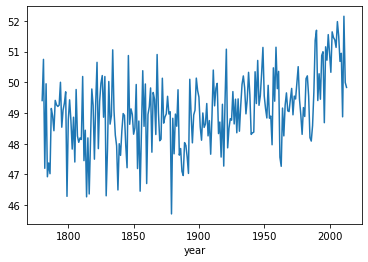

In [22]:
# how does the average temperature change over the years?
df.groupby('year').avg_temp_f.mean().plot()

<AxesSubplot:xlabel='month'>

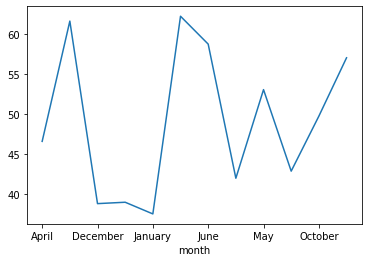

In [23]:
# how does the average temperature change over the months within a year?
df.groupby('month').avg_temp_f.mean().plot()

<AxesSubplot:>

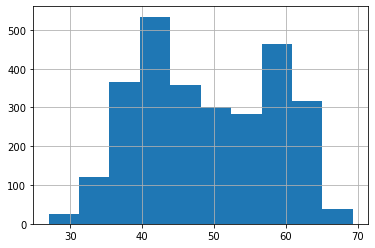

In [24]:
# average temperature distribution
df.avg_temp_f.hist()

<AxesSubplot:xlabel='year'>

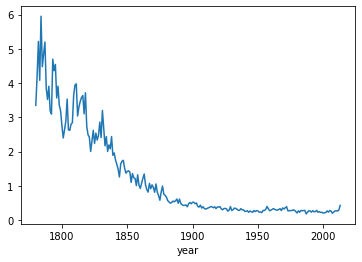

In [25]:
# how about the uncertainty change over all those years?
df.groupby('year').avg_temp_uncertainty.mean().plot()

### Takeaways:
- Average temperatures seem to be increasing each year
- Coldest times are at the beginning and end of the year, with warmest months being June - August
- The amount of uncertainty in temps was higher in earlier years, levels out about 1900
****************************************
## Split the Data
### Percentage - Based
I am only going to focus on average temperatures in fahrenheit, so I will drop the rest of the columns

In [26]:
# only going to look at date, and average temperature in fahrenheit
df = df[['avg_temp_f']]

In [27]:
df_size = len(df)
df_size

2804

In [28]:
# set train to 50% of total
train_size = int(len(df) * 0.5)
train_size

1402

In [29]:
# set validate to 30% of total
validate_size = int(len(df) * 0.3)
validate_size

841

In [30]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)
test_size

561

In [31]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

2243

In [32]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index:]

In [33]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

True

In [34]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,avg_temp_f
date,
1966-11-01,41.6570
1966-12-01,40.5716


In [35]:
train.columns

Index(['avg_temp_f'], dtype='object')

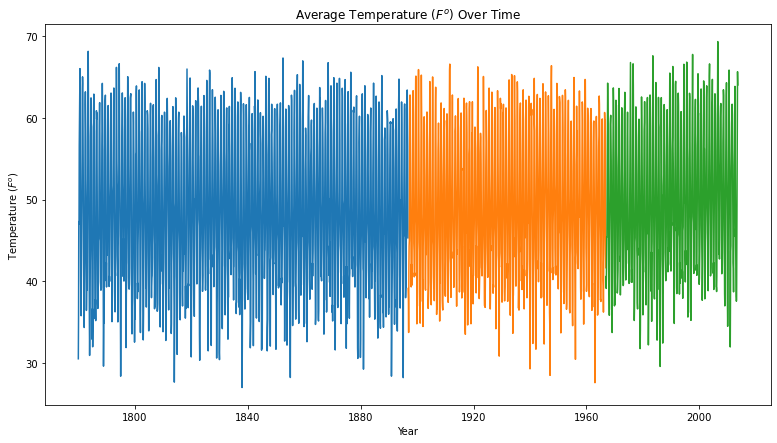

In [36]:
#visualize distribution
for col in train.columns:
    plt.figure(figsize=(13,7))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel('Temperature ($F^o$)')
    plt.xlabel('Year')
    plt.title('Average Temperature ($F^o$) Over Time')
    plt.show()

In [37]:
train.head()

,avg_temp_f
date,
1780-01-01,30.5078
1780-02-01,35.9708
1780-03-01,47.3018
1780-04-01,46.9904
1780-05-01,56.5952


In [38]:
# set y to the target variable
y = train.avg_temp_f.resample('M').mean()
y.head()

date
1780-01-31    30.5078
1780-02-29    35.9708
1780-03-31    47.3018
1780-04-30    46.9904
1780-05-31    56.5952
Freq: M, Name: avg_temp_f, dtype: float64

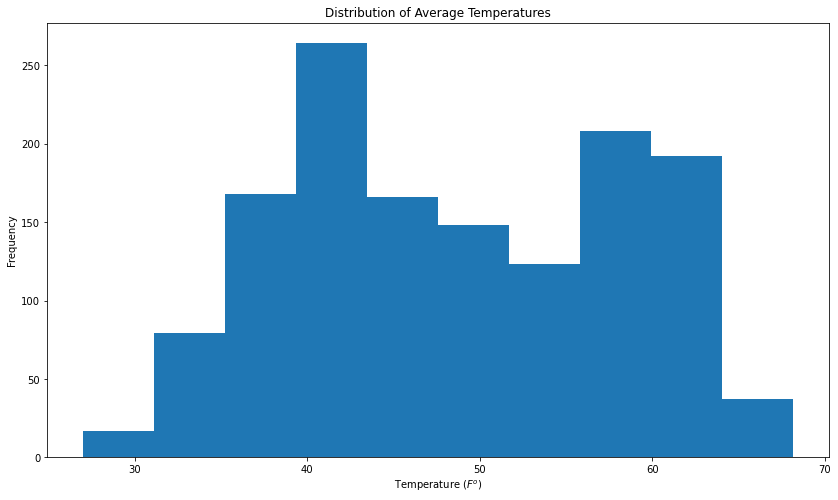

In [39]:
# plot distribution of target variable
plt.figure(figsize=(14, 8))
y.plot.hist()
plt.title('Distribution of Average Temperatures')
plt.xlabel('Temperature ($F^o$)')
None

In [40]:
y.head()

date
1780-01-31    30.5078
1780-02-29    35.9708
1780-03-31    47.3018
1780-04-30    46.9904
1780-05-31    56.5952
Freq: M, Name: avg_temp_f, dtype: float64

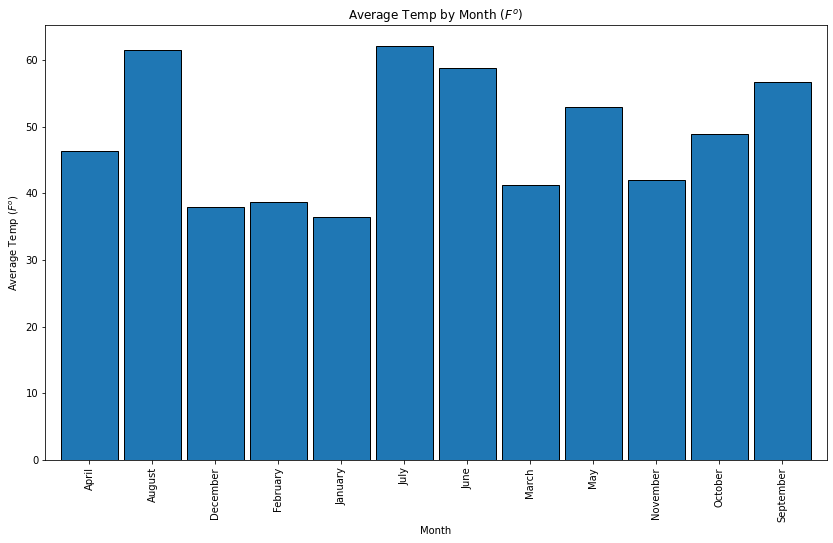

In [41]:
#graph average monthly temperature
plt.figure(figsize=(14, 8))
ax = y.groupby(y.index.month_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Temp by Month ($F^o$)', xlabel='Month', ylabel='Average Temp ($F^o$)')
None

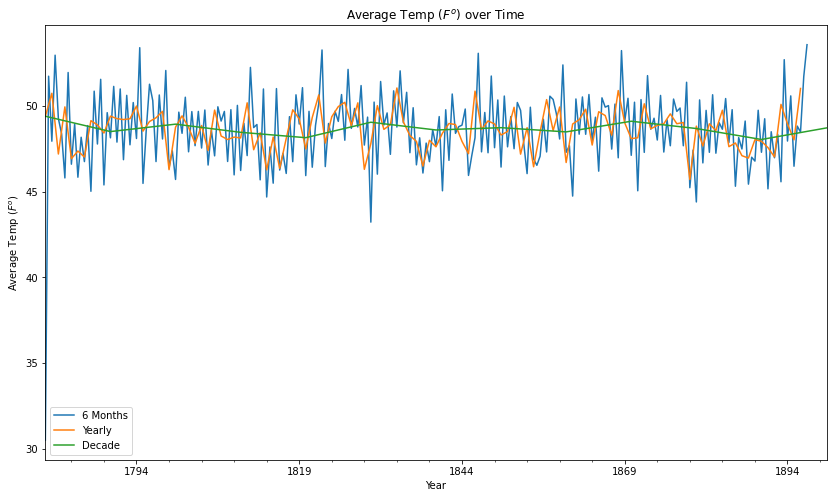

In [42]:
#look at temp over time, monthly/yearly
plt.figure(figsize=(14, 8))
y.resample('6M').mean().plot(label='6 Months')
y.resample('Y').mean().plot(label='Yearly')
y.resample('10Y').mean().plot(label='Decade')
plt.title('Average Temp ($F^o$) over Time')
plt.xlabel('Year')
plt.ylabel('Average Temp ($F^o$)')
plt.legend()

None

In [43]:
y = train.avg_temp_f.resample('10Y').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
1780-12-31,49.405550,49.405550,0.0,0.0
1790-12-31,48.510650,48.510650,0.0,0.0
1800-12-31,48.943490,48.943490,0.0,0.0
1810-12-31,48.466955,48.466955,0.0,0.0
1820-12-31,48.154475,48.154475,0.0,0.0


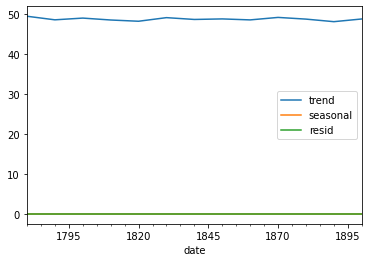

In [44]:
decomposition.iloc[:, 1:].plot()
None

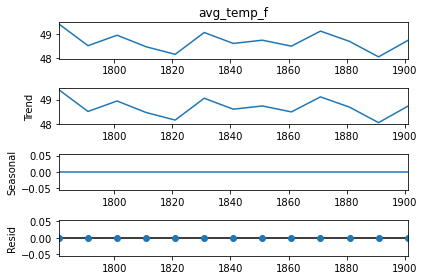

In [45]:
# the value returned from seasonal_decompose can itself be plotted
result.plot()
None

### Lag Plot

Text(0.5, 1.0, 'Lag plot with lag=1')

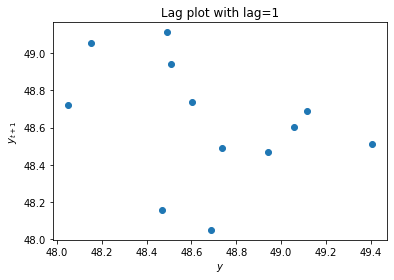

In [46]:
#Lag Plot
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

,this_5_years,next_5_years
date,,
1780-12-31,49.40555,48.43952
1785-12-31,48.43952,48.58178
1790-12-31,48.58178,49.25468
1795-12-31,49.25468,48.63230
1800-12-31,48.63230,48.45599


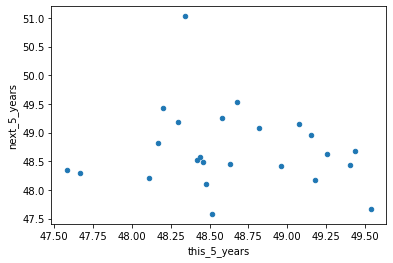

In [47]:
#resample to every 5 years, aggregate by mean
fiveyears = train.resample('5Y').mean()
#create column by next five years- lagplot to next 5 years
fiveyears['next_5_years'] = fiveyears.avg_temp_f.shift(-1)
#rename column
fiveyears = fiveyears.rename(columns={'avg_temp_f': 'this_5_years'})
#plot this period with next period
fiveyears.plot.scatter(x='this_5_years', y='next_5_years')
fiveyears.head()

### Autocorreleation Plot 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

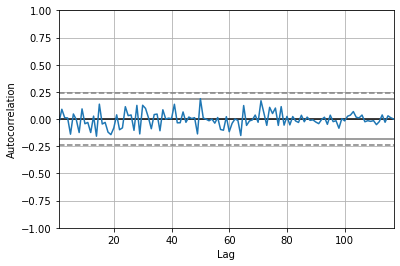

In [48]:
# auto correlation
pd.plotting.autocorrelation_plot(train.avg_temp_f.resample('Y').mean())

In [49]:
train = train.resample('5Y').mean()
# create a categorical feature
train['Temperature_bin'] = pd.qcut(train.avg_temp_f, 3, labels=['High Temp', 'Average Temp', 'Low Temp'])
train.groupby('Temperature_bin').mean()

,avg_temp_f
Temperature_bin,
High Temp,48.135077
Average Temp,48.640033
Low Temp,49.508626


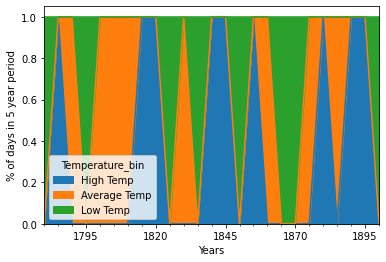

In [50]:
(train.groupby('Temperature_bin')
 .resample('5Y')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in 5 year period')
plt.xlabel('Years')
None

### Takeaways from Explore:
- temp has been gradually getting warmer over time
- July and August are the warmest months
- December and January are the coldest months

*********************************************************************

# Modeling

In [51]:
def make_predictions(temp):
    yhat_df = pd.DataFrame({'avg_temp_f': [temp]}, 
                       index = validate.index)
    return yhat_df

In [52]:
#take the last average temp in average temp - round 2 decimal places
last_observed = round(train['avg_temp_f'][-1:][0], 2)
last_observed

51.03

In [53]:
#plot and evaluate 
def plot_and_eval(yhat_df, target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(yhat_df, target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [54]:
#yhat has same index as validate
#define yhat
last_df = pd.DataFrame({'avg_temp_f': [last_observed]}, 
                       index = validate.index)

last_df.head(2)

,avg_temp_f
date,
1896-11-01,51.03
1896-12-01,51.03


In [55]:
yhat_df_lo = make_predictions(last_observed)
yhat_df_lo

,avg_temp_f
date,
1896-11-01,51.03
1896-12-01,51.03
1897-01-01,51.03
1897-02-01,51.03
1897-03-01,51.03
...,...
1966-07-01,51.03
1966-08-01,51.03
1966-09-01,51.03


In [56]:
target_var = 'avg_temp_f'

In [57]:
rmse_last = round(sqrt(mean_squared_error(validate[target_var], yhat_df_lo[target_var])), 5)

In [58]:
#create a dataframe to make data easier to visualize/understand
model_df = pd.DataFrame(data=[{
    'model': 'Last Observed Value',
    'rmse': rmse_last,
    'temperature': last_observed
    }])

model_df

,model,rmse,temperature
0,Last Observed Value,9.14392,51.03


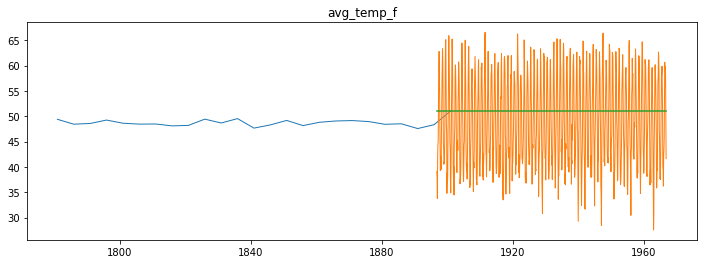

In [59]:
#plot last observed model vs actual
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label = 'Train', linewidth = 1)
plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df_lo[target_var])
plt.title(target_var)
plt.show()

# Simple Average Model

In [60]:
simple_average = round(train['avg_temp_f'].mean(), 2)

In [61]:
yhat_df_simple = make_predictions(simple_average)

In [62]:
rmse_simple = round(sqrt(mean_squared_error(validate[target_var], yhat_df_simple[target_var])), 5)

In [63]:

#create visual to see baseline vs LinearRegression model
model_df = model_df.append(
    {
    'model': 'Simple Average',
    'rmse': rmse_simple,
    'temperature': simple_average},
    ignore_index= True
    )

model_df

,model,rmse,temperature
0,Last Observed Value,9.14392,51.03
1,Simple Average,8.96002,48.74


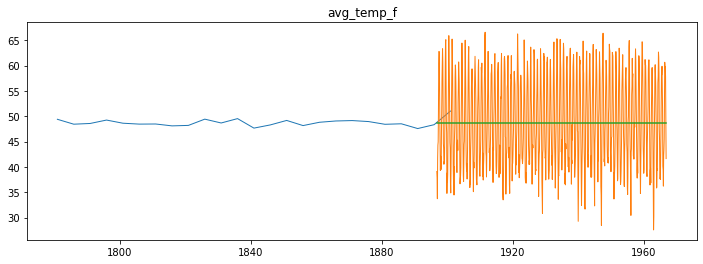

In [64]:
#plot simple average model vs actual
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label = 'Train', linewidth = 1)
plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df_simple[target_var])
plt.title(target_var)
plt.show()

# Rolling/Moving Average Model

In [65]:
# compute a 3 months rolling average 
period = 3
rolling_average = round(train['avg_temp_f'].rolling(period).mean()[-1], 2)

In [66]:
yhat_df_rolling = make_predictions(rolling_average)
yhat_df_rolling.head(3)

,avg_temp_f
date,
1896-11-01,48.98
1896-12-01,48.98
1897-01-01,48.98


In [67]:
rmse_rolling = round(sqrt(mean_squared_error(validate[target_var], yhat_df_rolling[target_var])), 5)

In [68]:
#create visual to see baseline vs LinearRegression model
model_df = model_df.append(
    {
    'model': 'Rolling Average',
    'rmse': rmse_rolling,
    'temperature': rolling_average},
    ignore_index= True
    )

model_df

,model,rmse,temperature
0,Last Observed Value,9.14392,51.03
1,Simple Average,8.96002,48.74
2,Rolling Average,8.95204,48.98


In [69]:
## Run on Test Dataset
period = 3
test_rolling = round(test['avg_temp_f'].rolling(period).mean().iloc[-1], 2)
yhat_df_test = make_predictions(test_rolling)
rmse_test = round(sqrt(mean_squared_error(validate[target_var], yhat_df_test[target_var])), 5)

In [70]:
#create visual to see baseline vs LinearRegression model
model_df = model_df.append(
    {
    'model': 'Test (rolling average)',
    'rmse': rmse_test,
    'temperature': test_rolling},
    ignore_index= True
    )

model_df

,model,rmse,temperature
0,Last Observed Value,9.14392,51.03
1,Simple Average,8.96002,48.74
2,Rolling Average,8.95204,48.98
3,Test (rolling average),16.24073,62.71


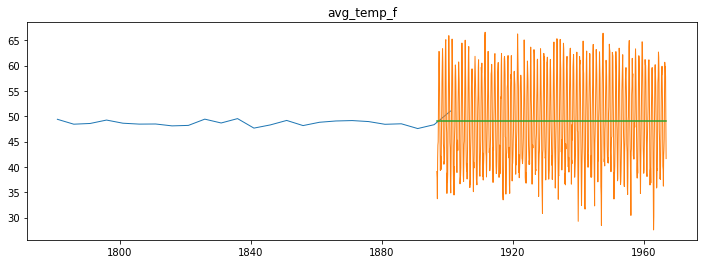

In [71]:
#plot rolling average model vs actual
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label = 'Train', linewidth = 1)
plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df_rolling[target_var])
plt.title(target_var)
plt.show()

### Takeaways from Modeling
- rolling averages model performed the best with an RMSE of 8.95204
- This model actually did not perform very well on the test set

## Final Takeaways
- rolling average (with a period of 3) performed best as a model 
- there are definate trends in the temperature
- over time the average temperature has remained about the same
- July and August have the hottest average temperature historically
- December and January have the lowest average temperatures historically

## Next Steps:
With more time:
- I would like to look further into 'Average Temperature Uncertainty'
- Look into Holt's Linear Trend model